In [1]:
import BioSimSpace as BSS
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
import glob
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import  GridSpec

import numpy as np
from itertools import chain
import os
import shutil
from functools import reduce

from rdkit import Chem
from rdkit.Chem import Draw, rdFMCS
from rdkit.ML.Scoring.Scoring import CalcBEDROC, CalcROC, CalcEnrichment
from importlib import reload

import itertools

In [2]:
# import from path (github clone) as a conda install is not available yet for freenrgworkflows.
import sys
sys.path.insert(1, '../../../BioSimSpaceTutorials/04_fep/freenrgworkflows/networkanalysis/')
import networkanalysis as networkanalysis_few
import experiments as experiments_few
import stats as stats_few

In [3]:
def computeStats(arr_1, arr_2):
    """return statistics on arrays"""
    r = round(stats.pearsonr(arr_1, arr_2)[0], 2)
    mue = round(mean_absolute_error(arr_1, arr_2), 2)
    tau = round(stats.kendalltau(arr_1, arr_2)[0], 2)

    return r, mue, tau


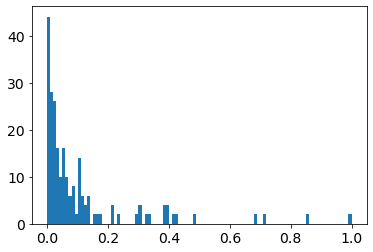

In [4]:
true_perts = pd.read_csv("input/testsets/tyk2/fep_data_tyk2_fc.csv")[["lig_1", "lig_2"]].values
true_perts = [ f"{pert[0]}~{pert[1]}" for pert in true_perts]
true_sems = pd.read_csv("input/testsets/tyk2/fep_data_tyk2_fc.csv")["error"].values
true_sems  = minmax_scale(1 /  true_sems, feature_range=(0,1))

plt.hist(true_sems, bins=100)
plt.show()

## make a dict with all perts and corresponding numbers of heavy atoms perturbed.

In [5]:

def CountHAChange(fragment1_mol, fragment2_mol):
    """Takes in two rdkit fragment molecules, counts heavy atom changes and returns the number."""
    fragA_smiles = Chem.MolToSmiles(fragA)
    fragB_smiles = Chem.MolToSmiles(fragB)  
    
    double_letter_elements = ["Cl", "Br", "Si"]

    # assign a score based on n_ha transformed:
    transform_score = 0
    for frag_A, frag_B in itertools.zip_longest(fragA_smiles.split("."), fragB_smiles.split(".")):

        # clean up the strings by just retaining letters for easier counting:
        if frag_A:
            fragA_atoms = ''.join(x for x in frag_A if x.isalpha())
        else:
            fragA_atoms = "X"
        if frag_B:
            fragB_atoms = ''.join(x for x in frag_B if x.isalpha())
        else:
            fragB_atoms = "X"
            
        
        # a substitution counts as a single-atom change:
        if len(fragA_atoms) == len(fragB_atoms):
            transform_score += 1
        
        elif len(fragA_atoms) != len(fragB_atoms):
            # add number of heavy atoms changed.
            if len(fragA_atoms) > len(fragB_atoms):
                transform_score += len(fragA_atoms)
            else:
                transform_score += len(fragB_atoms)
        
        # correct for double-letter elements by subtracting 1.
        for elem in double_letter_elements:
            if elem in fragA_atoms:
                transform_score -= 1
            if elem in fragB_atoms:
                transform_score -= 1
            

    return transform_score

In [6]:
all_lig_paths = glob.glob("input/testsets/tyk2/ligands/*.sdf")
all_perts = itertools.combinations(all_lig_paths, 2)

num_ha_perturbed = {} # useful for retrieving the number of perturbed HAs downstream in the notebook.

for pert in all_perts:
    ligA = Chem.SDMolSupplier(pert[0])[0]
    ligB = Chem.SDMolSupplier(pert[1])[0]
    
    mcs = rdFMCS.FindMCS([ligA, ligB], ringMatchesRingOnly=True, completeRingsOnly=True)

    # subtract the MCS to get the perturbed (i.e. non-mcs) atoms.
    fragA = Chem.ReplaceCore(ligA, Chem.MolFromSmarts(mcs.smartsString))
    fragB = Chem.ReplaceCore(ligB, Chem.MolFromSmarts(mcs.smartsString))

    # count the number of perturbed heavy atoms.
    ha_change_count = CountHAChange(fragA, fragB)

    # get the pert name (and the inverse).
    pert_name = pert[0].split("/")[-1].replace(".sdf","")+"~"+pert[1].split("/")[-1].replace(".sdf","")
    pert_name_inv = pert[1].split("/")[-1].replace(".sdf","")+"~"+pert[0].split("/")[-1].replace(".sdf","")

    # add both to the dict.
    num_ha_perturbed[pert_name] = ha_change_count
    num_ha_perturbed[pert_name_inv] = ha_change_count

## Compare 4ns true SEM edges with FEP-Space true SEM edges

In [7]:
def plotScatter(x, y, log_transf=True, xlabel="", ylabel=""):

    x_log = np.log(x)
    y_log = np.log(y)
    
    f, ax = plt.subplots(1,1, figsize=(4,4))
    ax.scatter(x, y)
    if log_transf:
        ax.set_xscale('log')
        ax.set_yscale('log')



    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if log_transf:
        r, mue, tau = computeStats(x_log, y_log)
    else:
        r, mue, tau = computeStats(x, y)

    ax.annotate("R: "+str(r), xy=(0.3, 0.9), xycoords="axes fraction", ha="right")
    ax.annotate("MUE "+str(mue), xy=(0.3, 0.8), xycoords="axes fraction", ha="right")
    ax.annotate(r"$\tau$: "+str(tau), xy=(0.3, 0.7), xycoords="axes fraction", ha="right")

    min_x_ax = min(min(x), min(y))*1.5
    max_y_ax = max(max(x), max(y))*1.5
    
    ax.set_xlim(min_x_ax, max_y_ax)
    ax.set_ylim(min_x_ax, max_y_ax)

    ax.plot([min_x_ax, max_y_ax], [min_x_ax, max_y_ax], color="black", zorder=-100)
    ax.set_title(f"n={len(x)}")
    plt.tight_layout()


In [8]:
fepspace_df = pd.read_csv("input/fepspace_sems_full.csv")

ddg_sems = []
fepspace_sems = []

for pert in pd.read_csv("input/testsets/tyk2/fep_data_tyk2_fc.csv").values:
    query_name = f"{pert[0]}~{pert[1]}_tyk2"
    ddg_sem = pert[-1]
    
    fepspace_sem = fepspace_df[fepspace_df['pert'] == query_name]['SEM'].values
    
    if len(fepspace_sem) > 0:
        ddg_sems.append(float(ddg_sem))
        fepspace_sems.append(float(fepspace_sem[0]))

#fepspace_sems = minmax_scale(fepspace_sems, feature_range=(min(ddg_sems), max(ddg_sems)))

## Correlate (FEP-EXP) versus SEM

In [9]:
# get the fep data.
fep_data = {}
with open("input/testsets/tyk2/fep_data_tyk2_fc.csv", "r") as readfile:
    reader = csv.reader(readfile)
    next(reader)
    for row in reader:
        fep_data["~".join(row[:2])] = row[2:]

In [10]:
# get the experimental data.
# copied from https://github.com/michellab/freenrgworkflows/blob/devel/networkanalysis/experiments.py#L80-L101
_kTkcal = 0.0019872041 * 300
_RTkcal = 1.987203611 * 300

error = None
error_list = []

data = pd.read_csv("input/testsets/tyk2/exp_data_tyk2.dat")

dG = []
for i in range(len(data)):
    r = float(data.iloc[i, 1] / data.iloc[0, 1])
    dG.append(_kTkcal * np.log(r))

    error_list.append(_kTkcal * np.log(2))
        
# Now we normalise the free energies
dG = dG - np.mean(dG)

exp_data = {}
exp_data_ha = {}
for i in range(len(data)):
    lig = data.iloc[i, 0] 
    freenrg = dG[i]
    error = error_list[i] # don't need this in plot.
    exp_data[lig] = freenrg   


In [11]:
fep_sems = []
fep_minus_exp_freenrgs = []
fep_minus_exp_freenrgs_HAs = []

for pert, fep_outputs in fep_data.items():
    # get the FEP predictions as floats.
    fep_sem = float(fep_outputs[1])
    fep_freenrg = float(fep_outputs[0])
    
    # get the experimental values for each pert.
    lig_1, lig_2 = pert.split("~")
    exp_ddg = exp_data[lig_2] - exp_data[lig_1]

    # compute the absolute FEP-EXP variance.
    abs_fep_minus_exp = abs(fep_freenrg - exp_ddg)
    fep_minus_exp_freenrgs.append(abs_fep_minus_exp)
    fep_sems.append(fep_sem)
    
    # get the number of perturbed heavy atoms for this pert.
    fep_minus_exp_freenrgs_HAs.append(num_ha_perturbed[pert])


In [12]:
# what about FEP-Space SEM vs ddGoffset?
fepspace_sems = []
ddg_offsets_matched = []
ddg_offsets_matched_HAs = []

for pert, fep_outputs in fep_data.items():
    query_name = f"{pert}_tyk2"
    
    # get the FEP predictions as floats.
    fep_sem = float(fep_outputs[1])
    fep_freenrg = float(fep_outputs[0])
    
    # get the experimental values for each pert.
    lig_1, lig_2 = pert.split("~")
    exp_ddg = exp_data[lig_2] - exp_data[lig_1]

    # compute the absolute FEP-EXP variance.
    abs_fep_minus_exp = abs(fep_freenrg - exp_ddg)
    
    # get the FEP-Space SEM.
    fepspace_sem = fepspace_df[fepspace_df['pert'] == query_name]['SEM'].values
    
    if len(fepspace_sem) > 0: # i.e. if found in FEP-Space.
        fepspace_sems.append(float(fepspace_sem))
        ddg_offsets_matched.append(float(abs_fep_minus_exp))
        
        # get the number of perturbed heavy atoms for this pert.
        ddg_offsets_matched_HAs.append(num_ha_perturbed[pert])

In [13]:
# what about predicted SEM vs ddGoffset?
pred_sems = []
ddg_offsets = []


fepnn_preds = []
for input_file in glob.glob("output/series_predictions/tyk2_*.csv"):

    fepnn_df = pd.read_csv(input_file) # can keep the last df as the source df because all other columns are the same.

    fepnn_preds.append(fepnn_df["pred_sem_mean"].values)

fepnn_df["pred_sem_mean"] = np.mean(fepnn_preds, axis=0)
fepnn_df["pred_sem_std"] = np.std(fepnn_preds, axis=0)

n_ha_perturbed_C_D = []
offsets_perts_dict = {}
for pert, fep_outputs in fep_data.items():
    query_name = f"{pert}_tyk2"
    
    # get the FEP predictions as floats.
    fep_sem = float(fep_outputs[1])
    fep_freenrg = float(fep_outputs[0])
    
    # get the experimental values for each pert.
    lig_1, lig_2 = pert.split("~")
    exp_ddg = exp_data[lig_2] - exp_data[lig_1]

    # compute the absolute FEP-EXP variance.
    abs_fep_minus_exp = abs(fep_freenrg - exp_ddg)
    
    # get the FEP-NN predicted SEM.
    pred_sem = fepnn_df[fepnn_df['pert_name'] == pert]['pred_sem_mean'].values
    
    # get the number of perturbed heavy atoms.
    n_ha = fepnn_df[fepnn_df['pert_name'] == pert]['num_ha_change'].values[0]
    n_ha_perturbed_C_D.append(n_ha)
    
    pred_sems.append(float(pred_sem[0]))
    ddg_offsets.append(float(abs_fep_minus_exp))
    offsets_perts_dict[pert] = float(abs_fep_minus_exp)

In [14]:
# what about LOMAP-scores?
lomap_scores_dict = {}
with open("process/lomap/lomap_workdir/outputs/lomap_score_with_connection.txt", "r") as lomap_file:
    reader = csv.reader(lomap_file)
    next(reader)
    for row in reader:
        cleaned_row = [ item.replace(" ","") for item in row ]
        
        lig1 = "_".join(cleaned_row[2].split("_")[1:]).split(".")[0]
        lig2 = "_".join(cleaned_row[3].split("_")[1:]).split(".")[0]
        pert = lig1+"~"+lig2
        lomap_score = float(cleaned_row[4])
        lomap_scores_dict[pert] = lomap_score
        
        # lomap's mtx edges are monodirectional, but our predictions are bidirectional. Write both directions.
        inv_pert = lig2+"~"+lig1
        lomap_scores_dict[inv_pert] = lomap_score

ddg_offsets = []
lomap_scores = []

for pert, fep_outputs in fep_data.items():
    query_name = f"{pert}_tyk2"
    
    # get the FEP predictions as floats.
    fep_sem = float(fep_outputs[1])
    fep_freenrg = float(fep_outputs[0])
    
    # get the experimental values for each pert.
    lig_1, lig_2 = pert.split("~")
    exp_ddg = exp_data[lig_2] - exp_data[lig_1]

    # compute the absolute FEP-EXP variance.
    abs_fep_minus_exp = abs(fep_freenrg - exp_ddg)
    
    ddg_offsets.append(abs_fep_minus_exp)
    lomap_scores.append(1/ lomap_scores_dict[pert])

In [15]:
# let's do that again, but now scale the LOMAP score to the ddGoffset range. 
lomap_scores_scaled = minmax_scale(lomap_scores, feature_range=(min(ddg_offsets), max(ddg_offsets)))


### Make a nice subplots figure with all of these correlations.

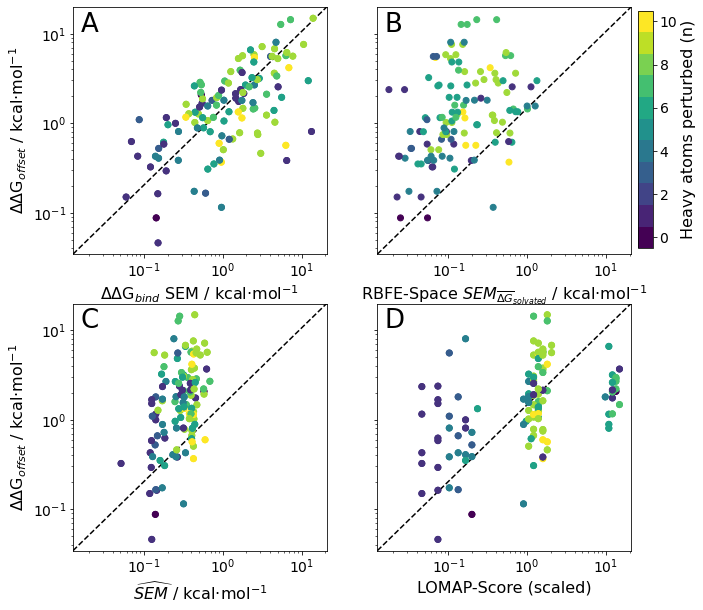

In [16]:
f, axes = plt.subplots(2, 2, figsize=(10,10), sharey=True, sharex=True)

# top left. ddgbind vs sem
axes[0][0].scatter(fep_sems, fep_minus_exp_freenrgs, c=fep_minus_exp_freenrgs_HAs)
axes[0][0].set_xlabel(r"$\Delta\Delta$G$_{bind}$ SEM / kcal$\cdot$mol$^{-1}$")
axes[0][0].set_ylabel(r"$\Delta\Delta$G$_{offset}$ / kcal$\cdot$mol$^{-1}$")

# top right. fepspace sem vs offset
axes[0][1].scatter(fepspace_sems, ddg_offsets_matched, c=ddg_offsets_matched_HAs)
axes[0][1].set_xlabel("RBFE-Space $SEM_{\overline{\Delta{G}}_{solvated}}$ / kcal$\cdot$mol$^{-1}$")

# bottom left. pred sem vs offset
axes[1][0].scatter(pred_sems, ddg_offsets, c=n_ha_perturbed_C_D)
axes[1][0].set_xlabel(r"$\widehat{SEM}$ / kcal$\cdot$mol$^{-1}$")
axes[1][0].set_ylabel(r"$\Delta\Delta$G$_{offset}$ / kcal$\cdot$mol$^{-1}$")

# bottom right. LOMAP vs offset
# bottom left. pred sem vs offset
axes[1][1].scatter(lomap_scores_scaled, ddg_offsets, c=n_ha_perturbed_C_D)
axes[1][1].set_xlabel(r"LOMAP-Score (scaled)")


for ax, index in zip(axes.flatten(), ["A", "B", "C", "D"]):
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", zorder=-10, c="black")
    ax.annotate(index, xy=(0.03, 0.9), xycoords="axes fraction", size=26)


# turn x axis labels back on for A/B
axes[0][0].xaxis.set_tick_params(labelbottom=True)
axes[0][1].xaxis.set_tick_params(labelbottom=True)

# add colourbar.
ax2 = f.add_axes([0.91, 0.545, 0.02, 0.33])
cb = mpl.colorbar.ColorbarBase(ax2, values=np.arange(0,11), label="Heavy atoms perturbed (n)",
                              orientation='vertical')

# plt.tight_layout()
plt.savefig("/home/jscheen/projects/FEPSPACE/figures/tyk2_ddg_offset_corrs_scatters.png", dpi=300)
plt.show()

### Write a file where True SEM is replaced with ddGoffset that we can use for network generation.

In [17]:
ddGoffset_dict = {}
for pert, fep_outputs in fep_data.items():
    # get the FEP predictions as floats.
    fep_sem = float(fep_outputs[1])
    fep_freenrg = float(fep_outputs[0])
    
    # get the experimental values for each pert.
    lig_1, lig_2 = pert.split("~")
    exp_ddg = exp_data[lig_2] - exp_data[lig_1]

    # compute the absolute FEP-EXP variance.
    abs_fep_minus_exp = abs(fep_freenrg - exp_ddg)
    ddGoffset_dict[pert] = abs_fep_minus_exp
    
    

In [18]:
with open("input/testsets/tyk2/fep_data_tyk2_fc.csv", "r") as readfile, \
     open("input/testsets/tyk2/fep_data_tyk2_fc_ddGoffset.csv", "w") as writefile:
        reader = csv.reader(readfile)
        writer = csv.writer(writefile)
        for row in reader:
            if row[0] == "lig_1":
                writer.writerow(row) # copies over the header.
            else:
                pert = f"{row[0]}~{row[1]}"
                ddGoffset = ddGoffset_dict[pert]
                row[-1] = ddGoffset # replaces SEM with ddGoffset value.
                writer.writerow(row)
    

# Merck set network generation - LOMAP-Score and FEPNN SEM.

In [19]:
def writeTransformations(transfs, ligand_names, filename):
    """writes a simple CSV file containing all perturbations picked by LOMAP."""
    with open(filename, "w") as writefile:
        writer = csv.writer(writefile)
        for liga, ligb in transfs:
            writer.writerow([f"{ligand_names[liga]}~{ligand_names[ligb]}"])
            
    

In [20]:
tgt_to_run = "tnks2"

### Naive LOMAP

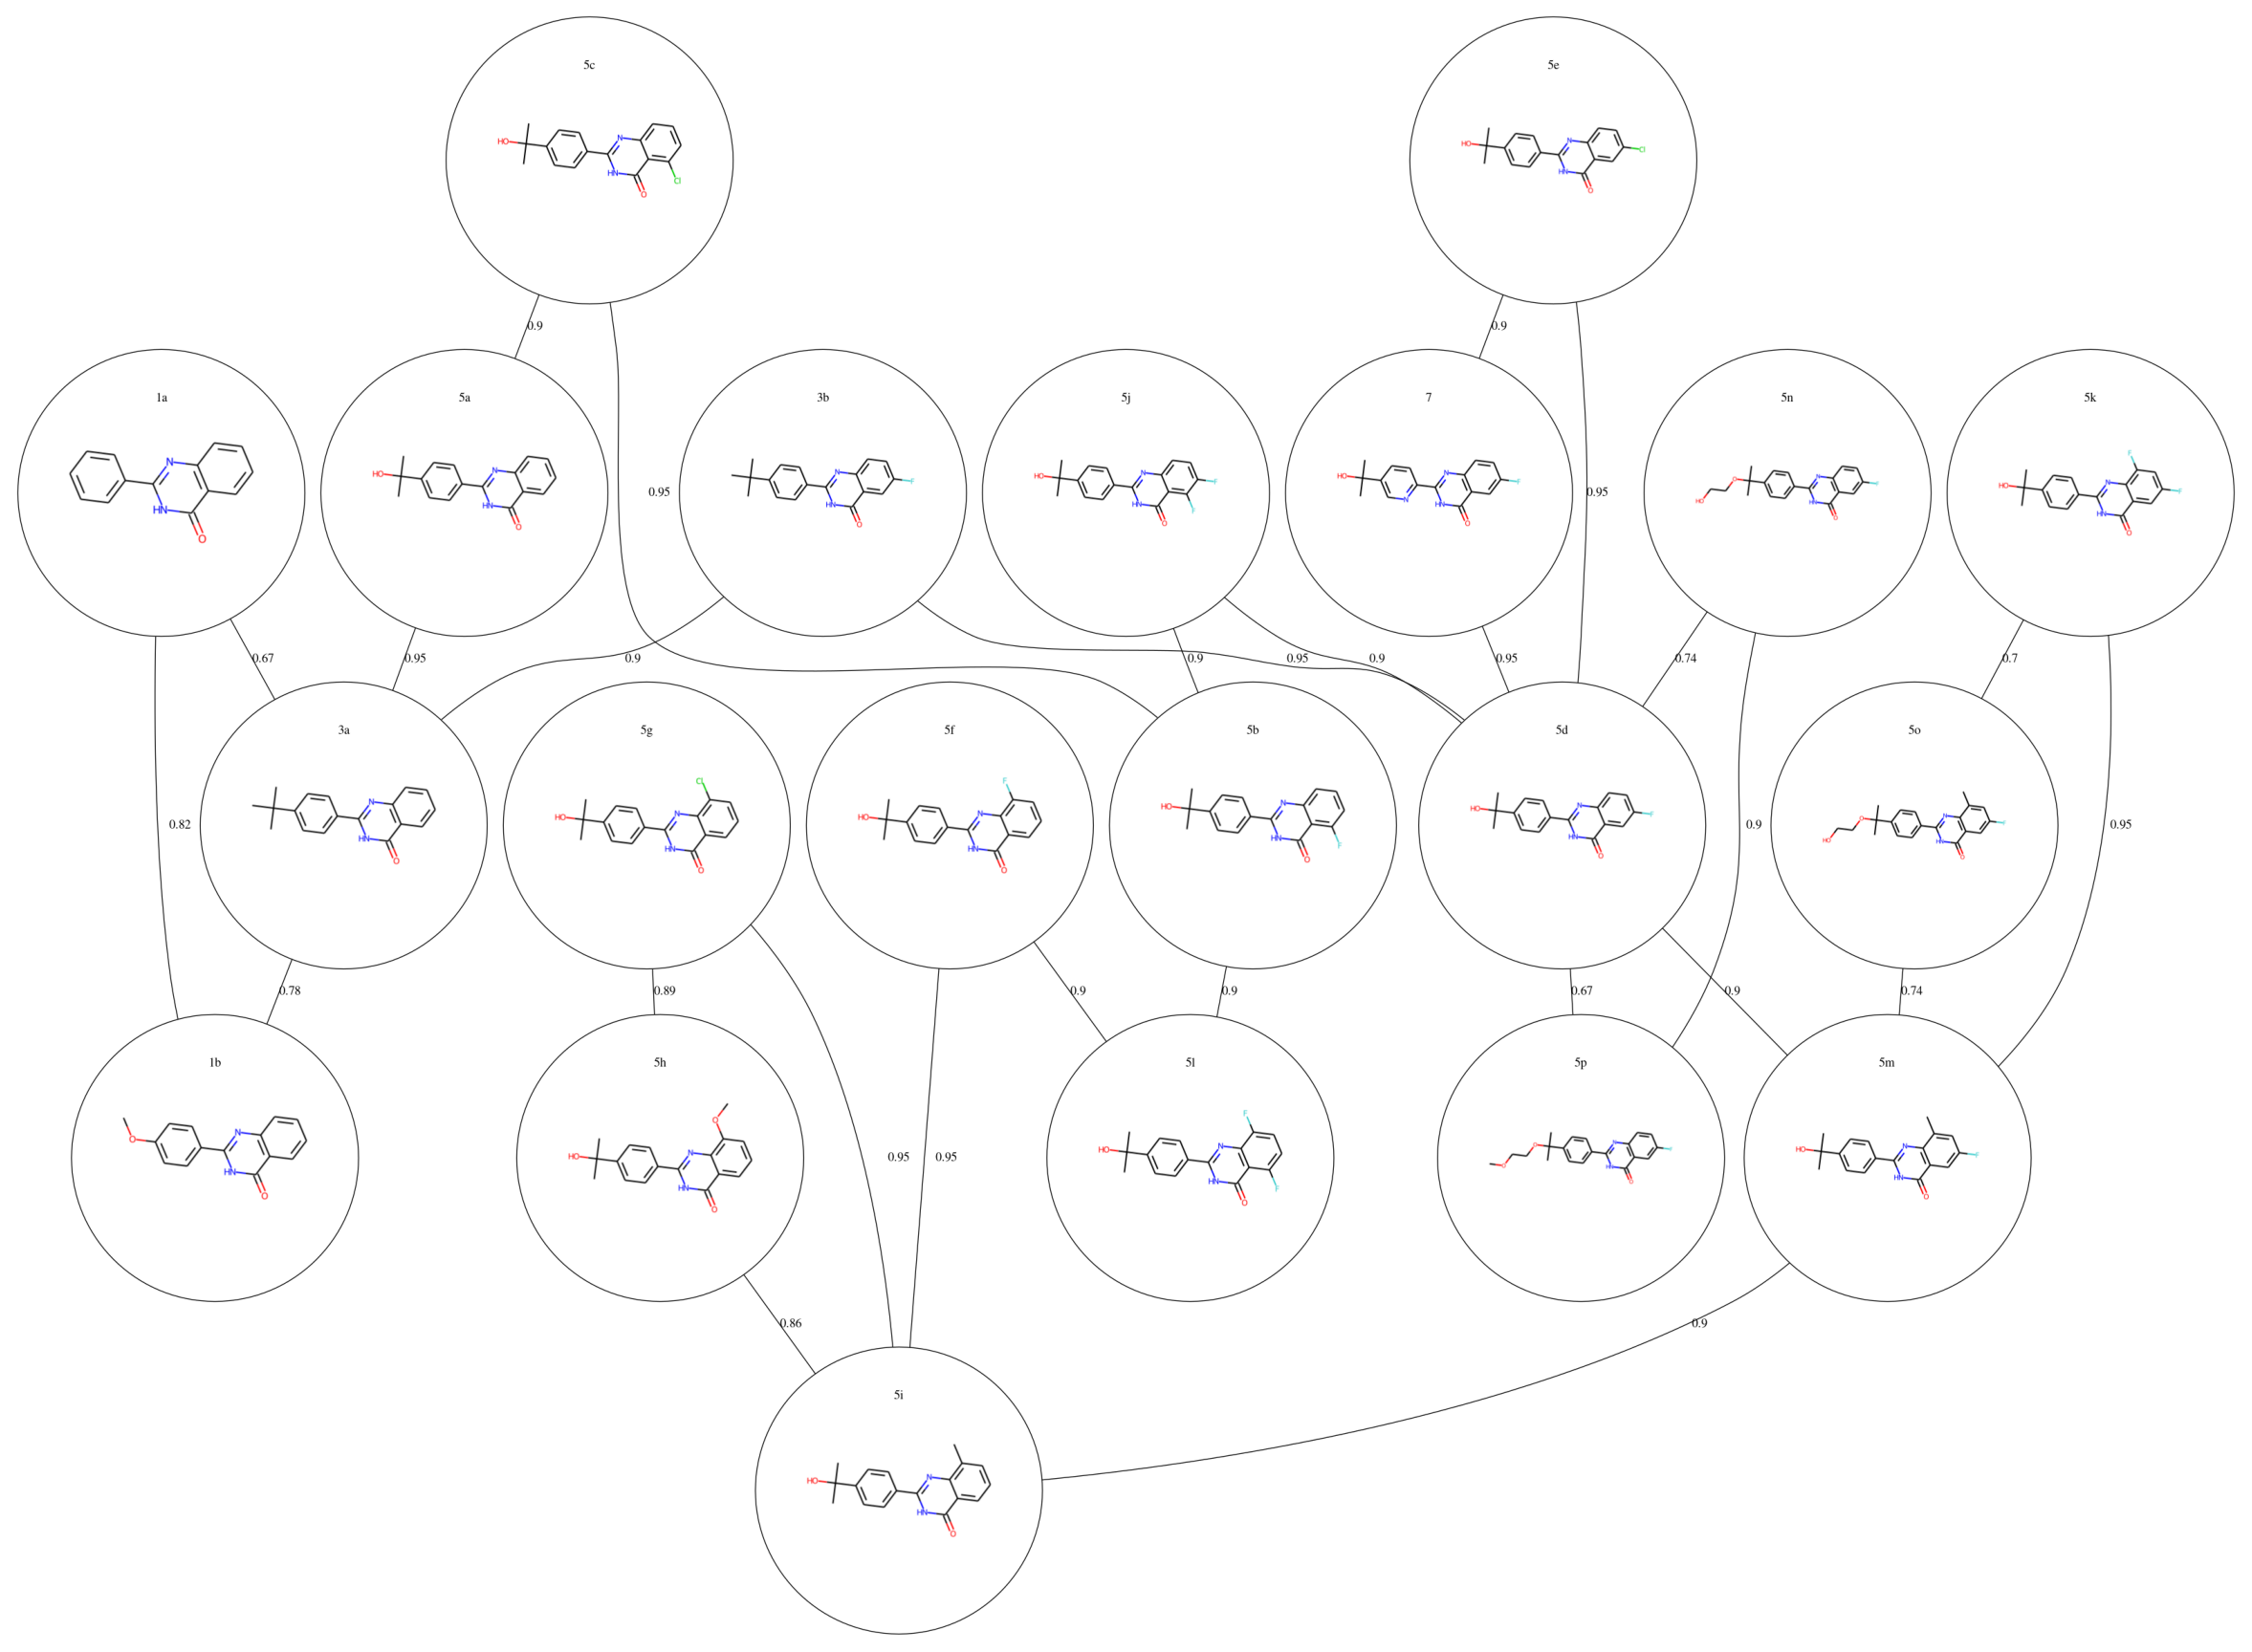

In [21]:
path_to_ligands = f"/home/jscheen/projects/FEPSPACE/fep_ref_ligands/{tgt_to_run}"
ligand_files = glob.glob(f"{path_to_ligands}/*.sdf")

runner_work_dir = "tmp/lomap"
if os.path.exists(runner_work_dir):
    shutil.rmtree(runner_work_dir)


ligands = []
ligand_names = []

for filepath in ligand_files:
    if "8" in filepath:
        continue
    # append the molecule object to a list.
    ligands.append(Chem.SDMolSupplier(filepath)[0])
    
    # append the molecule name to another list so that we can use the name of each molecule in our workflow.
    ligand_names.append(filepath.split("/")[-1].replace(".sdf",""))

tranformations, lomap_scores_tnks2 = BSS.Align.generateNetwork(ligands, plot_network=True, names=ligand_names, 
                                                         work_dir=runner_work_dir,
                                                         #links_file="tmp/links_file.in"
                                                        )

In [22]:
writeTransformations(tranformations, ligand_names, 
                     filename=f"output/series_predictions/{tgt_to_run}_lomap_perts.csv")

### FEP-NN LOMAP

In [23]:
def scaleArray(arr):
    """Scales an array to be the inverse in the range [0-1]."""
    
    # normalise to the range 0-1.
    return minmax_scale(1 /  arr, feature_range=(0,1))


In [24]:
# get the FEPNN SEM prediction per ligand.
perts = {}
for cats_file in glob.glob(f"output/series_predictions/{tgt_to_run}_*"):
    
    if "network" in cats_file or "lomap" in cats_file \
    or "fepnn" in cats_file or "combined" in cats_file:
        continue
    with open(cats_file, "r") as readfile:
        reader = csv.reader(readfile)
        next(reader)
        for row in reader:
            pert = row[0]
            pred_sem = float(row[1])
            
            if not pert in perts:
                perts[pert] = [pred_sem]
            else:
                perts[pert].append(pred_sem)
                
# compute the mean SEM prediction per pert.
pert_names = []
pert_sems = []
for pert, sems in perts.items():
    mean_sem = np.mean(sems)
    pert_names.append(pert)
    pert_sems.append(float(mean_sem))

# now scale the sems to [0-1].
pert_sems = scaleArray(np.array(pert_sems))

for pert, val in zip(pert_names, pert_sems):
    perts[pert] = val

In [25]:
written = []
with open("tmp/links_file.in", "w") as writefile:
    writer = csv.writer(writefile, delimiter =" ")
    
    for pert_name, value in perts.items():
        # find the lomap filename for both ligs.
        liga_lomap_name = None
        ligb_lomap_name = None
        for filename in glob.glob("tmp/lomap/inputs/*.sdf"):
            if "lig_8" in filename:
                continue # exclude +1 ligands from tnks2 set.
            if pert_name.split("~")[0] in filename:
                liga_lomap_name = filename.split("/")[-1]
            elif pert_name.split("~")[1] in filename:
                ligb_lomap_name = filename.split("/")[-1]
            
            if liga_lomap_name and ligb_lomap_name:
                if not [liga_lomap_name, ligb_lomap_name] in written:
                    writer.writerow([liga_lomap_name, ligb_lomap_name, value])
                    
                    written.append([liga_lomap_name, ligb_lomap_name])
                

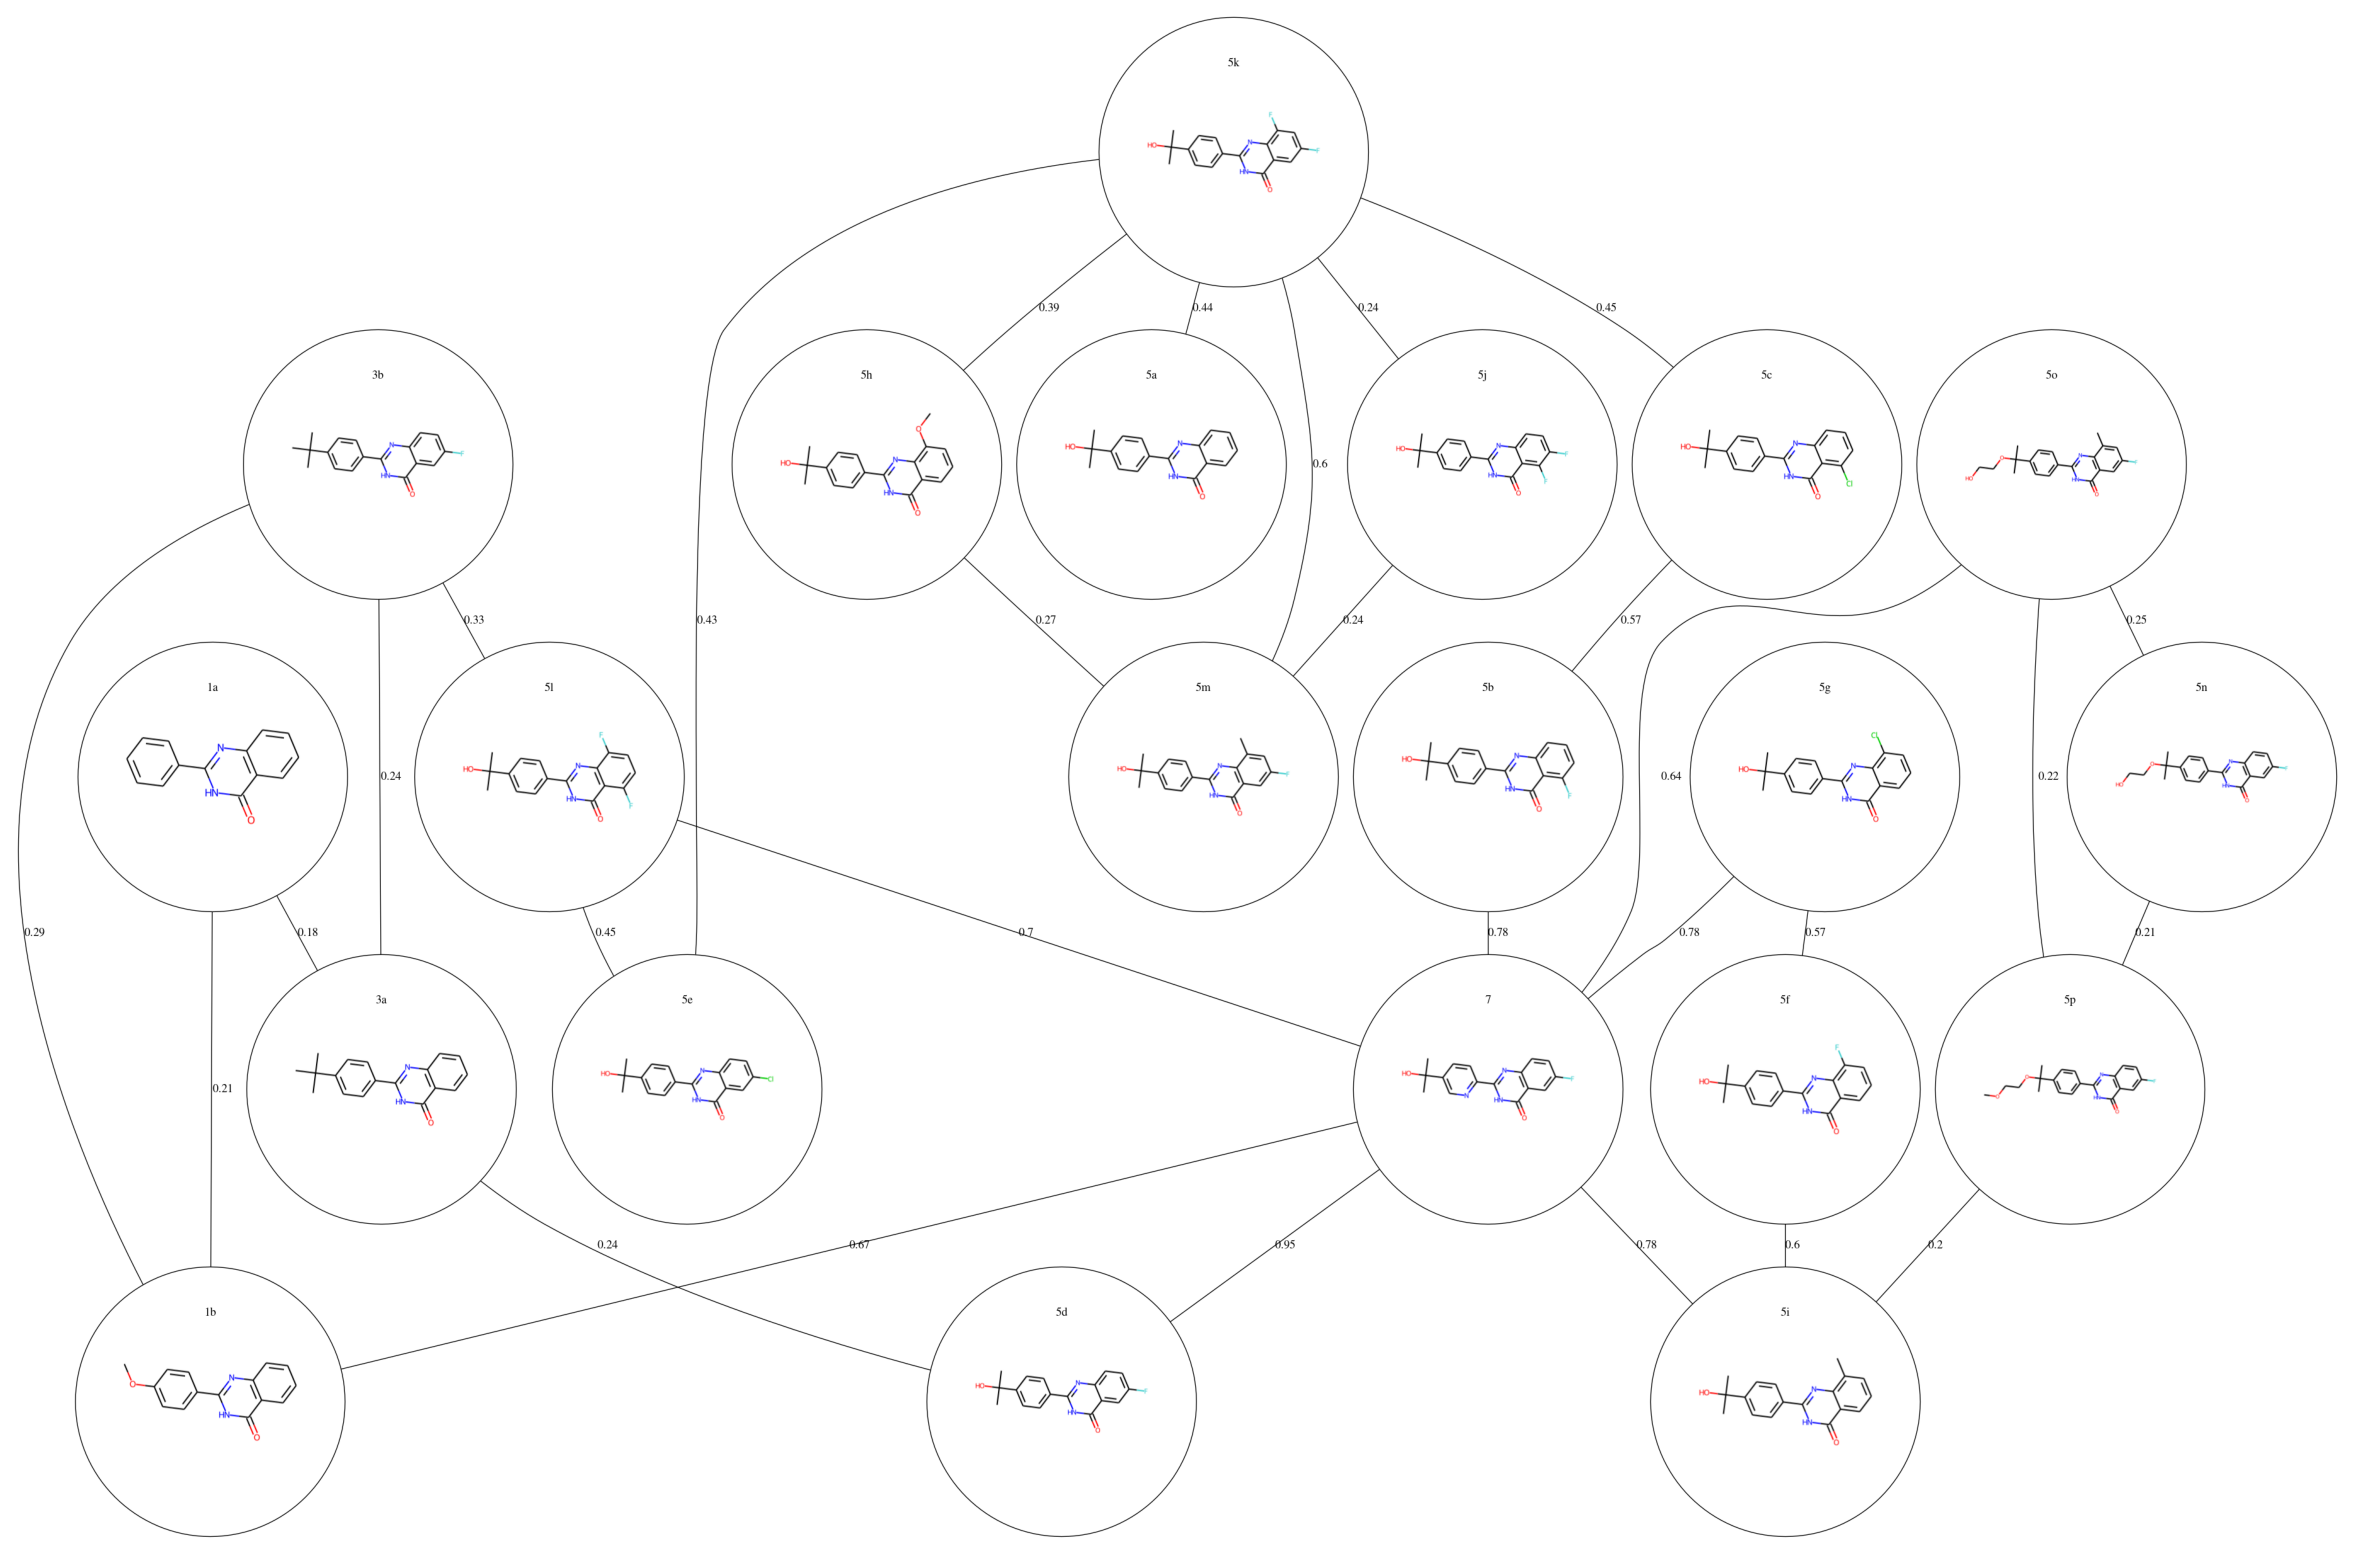

In [26]:
path_to_ligands = f"/home/jscheen/projects/FEPSPACE/fep_ref_ligands/{tgt_to_run}"
ligand_files = glob.glob(f"{path_to_ligands}/*.sdf")

runner_work_dir = "tmp/lomap"
if os.path.exists(runner_work_dir):
    shutil.rmtree(runner_work_dir)


ligands = []
ligand_names = []

for filepath in ligand_files:
    
    if "8" in filepath:
        continue # exclude +1 ligands from tnks2 set.
            
    # append the molecule object to a list.
    ligands.append(Chem.SDMolSupplier(filepath)[0])
    
    # append the molecule name to another list so that we can use the name of each molecule in our workflow.
    ligand_names.append(filepath.split("/")[-1].replace(".sdf",""))

tranformations_fepnn, lomap_scores_tnks2 = BSS.Align.generateNetwork(ligands, plot_network=True, names=ligand_names, 
                                                         work_dir=runner_work_dir,
                                                         links_file="tmp/links_file.in"
                                                        )

In [27]:
writeTransformations(tranformations_fepnn, ligand_names, 
                     filename=f"output/series_predictions/{tgt_to_run}_fepnn_perts.csv")

In [28]:
# write a file that contains the unique perts, 1 direction only. 
perts = []

with open("output/series_predictions/tnks2_fepnn_perts.csv", "r") as fepnn_file, \
        open("output/series_predictions/tnks2_lomap_perts.csv", "r") as lomap_file:
    reader_fepnn = csv.reader(fepnn_file)
    reader_lomap = csv.reader(lomap_file)
    
    for pert in reader_fepnn:
        perts.append(pert)
    for pert in reader_lomap:
        perts.append(pert)
        
filtered_perts = []
filtered_out = 0
for pert in perts:
    
    inv_pert = pert[0].split("~")[1]+"~"+pert[0].split("~")[0]
    
    if not pert[0] in filtered_perts and not inv_pert in filtered_perts:
        filtered_perts.append(pert[0])
    else:
        print(pert[0])
        filtered_out += 1
print(f"Removed {filtered_out} duplicate perts.")

1a~3a
1a~1b
5k~5m
5c~5b
3b~3a
5f~5i
7~5d
5n~5p
Removed 8 duplicate perts.


In [29]:
with open(f"output/series_predictions/{tgt_to_run}_combined_perts.csv", "w") as writefile:
    writer = csv.writer(writefile)
    for pert in filtered_perts:
        writer.writerow([pert])
print(f"Total number of perturbations: {len(filtered_perts)}")

Total number of perturbations: 48


# TYK2: errors/correlations

In [30]:
# get the true TYK2 SEMs of ddGbind. We ran the fully-connected network for this set, so we have the data. 
import math

# get the free and bound sems for the fully-connected TYK2 network that we've done the FEPs for.
tyk2_sem_dict_free = {}
tyk2_sem_dict_bound = {}

for idx, row in pd.read_csv("input/testsets/tyk2/compiled_mbar_freenrgs.csv").iterrows():
    pert_name = "_".join(row["pert"].split("_")[:-1])
    inv_pert_name = "~".join([pert_name.split("~")[1], pert_name.split("~")[0]])
    sem = row[-1]
    
    if "free" in row[0]:
        tyk2_sem_dict_free[pert_name] = sem
        tyk2_sem_dict_free[inv_pert_name] = sem
    elif "bound" in row[0]:
        tyk2_sem_dict_bound[pert_name] = sem
        tyk2_sem_dict_bound[inv_pert_name] = sem

max_free_sem = np.nanmax(list(tyk2_sem_dict_free.values()))
max_bound_sem = np.nanmax(list(tyk2_sem_dict_bound.values()))

# replace all nans with the highest value.
for k,v in tyk2_sem_dict_free.items():
    if math.isnan(v):
        tyk2_sem_dict_free[k] = max_free_sem
for k,v in tyk2_sem_dict_bound.items():
    if math.isnan(v):
        tyk2_sem_dict_bound[k] = max_bound_sem

In [31]:
# now also compute ddg sems.
tyk2_sem_dict_ddg = {}

for pert, free_sem in tyk2_sem_dict_free.items():
    bound_sem = tyk2_sem_dict_bound[pert]
    
    # propagate the error.
    prop_sem = np.sqrt(free_sem**2 + bound_sem**2)
    tyk2_sem_dict_ddg[pert] = prop_sem

In [32]:
# make the array for each SEM type. Order of perts can be retrieved from other array sources.
tyk2_sems_free = []
tyk2_sems_bound = []
tyk2_sems_ddg = []

for idx, row in fepnn_df.iterrows():
    pert = row["pert_name"].replace("lig_", "")
    tyk2_sems_free.append(tyk2_sem_dict_free[pert])
    tyk2_sems_bound.append(tyk2_sem_dict_bound[pert])
    tyk2_sems_ddg.append(tyk2_sem_dict_ddg[pert])

## Generate stats.

In [33]:
# first scale the arrays to match ddGoffsets. If not then MUEs will be very high because distributions don't match.
tyk2_sems_ddg_s = minmax_scale(fep_sems,  feature_range=(min(ddg_offsets), max(ddg_offsets)))
# tyk2_sems_bound_s = minmax_scale(tyk2_sems_bound,  feature_range=(min(ddg_offsets), max(ddg_offsets)))
# tyk2_sems_free_s = minmax_scale(tyk2_sems_free,  feature_range=(min(ddg_offsets), max(ddg_offsets)))

fepspace_sems_s = minmax_scale(fepspace_sems,  feature_range=(min(ddg_offsets_matched), max(ddg_offsets_matched)))
pred_sems_s = minmax_scale(pred_sems,  feature_range=(min(ddg_offsets), max(ddg_offsets)))
lomap_scores_s = minmax_scale(1-np.array(lomap_scores),  feature_range=(min(ddg_offsets), max(ddg_offsets)))
ecfp6_s = minmax_scale(1-fepnn_df["fp_similarity"].values,  feature_range=(min(ddg_offsets), max(ddg_offsets)))
random_vals = np.random.uniform(low=min(ddg_offsets), high=max(ddg_offsets), size=(len(ddg_offsets),))

In [34]:
r_vals, mue_vals, tau_vals = [], [], []
for ref_arr in [tyk2_sems_ddg_s,
#                 tyk2_sems_bound_s,
#                 tyk2_sems_free_s,
                fepspace_sems_s,
                pred_sems_s,
                lomap_scores_s,
                ecfp6_s,
                random_vals]:
    try:
        r_val, mue_val, tau_val = computeStats(np.log(ref_arr), np.log(ddg_offsets))
    except ValueError:
        r_val, mue_val, tau_val = computeStats(np.log(ref_arr), np.log(ddg_offsets_matched))
    r_vals.append(r_val)
    mue_vals.append(mue_val)
    tau_vals.append(tau_val)


In [35]:
stats_df = pd.DataFrame({
    "Pearson r": r_vals,
    "MUE": mue_vals,
    "Kendall $\tau$" : tau_vals,
             }, index=[
    "$SEM_{\overline{\Delta\Delta{G}}_{bind}}$",
#     "$SEM_{\overline{\Delta{G}}_{bound}}$",
#     "$SEM_{\overline{\Delta{G}}_{solvated}}$",
    "FEP-Space $SEM_{\overline{\Delta{G}}_{solvated}}$", 
    "FEPNN $\widehat{SEM}$", 
    "LOMAP-Score (Scaled)",
    "ECFP6 similarity (Scaled)",
    "Random"
                      ])
stats_df

,Pearson r,MUE,Kendall $\tau$
$SEM_{\overline{\Delta\Delta{G}}_{bind}}$,0.63,0.85,0.46
FEP-Space $SEM_{\overline{\Delta{G}}_{solvated}}$,0.37,0.97,0.28
FEPNN $\widehat{SEM}$,0.41,1.40,0.25
LOMAP-Score (Scaled),-0.16,2.14,-0.33
ECFP6 similarity (Scaled),-0.03,1.93,-0.01
Random,0.03,1.69,0.01


In [36]:
print(stats_df.to_latex(index=True, escape=False))

\begin{tabular}{lrrr}
\toprule
{} &  Pearson r &   MUE &  Kendall $\tau$ \\
\midrule
$SEM_{\overline{\Delta\Delta{G}}_{bind}}$         &       0.63 &  0.85 &            0.46 \\
FEP-Space $SEM_{\overline{\Delta{G}}_{solvated}}$ &       0.37 &  0.97 &            0.28 \\
FEPNN $\widehat{SEM}$                             &       0.41 &  1.40 &            0.25 \\
LOMAP-Score (Scaled)                              &      -0.16 &  2.14 &           -0.33 \\
ECFP6 similarity (Scaled)                         &      -0.03 &  1.93 &           -0.01 \\
Random                                            &       0.03 &  1.69 &            0.01 \\
\bottomrule
\end{tabular}



Excluding MUE because it isn't statistically tractable to compute the mean error between two different arrays (SEM=statistical error, ddGoffset=systematic error).

# Scoring heuristics distributions

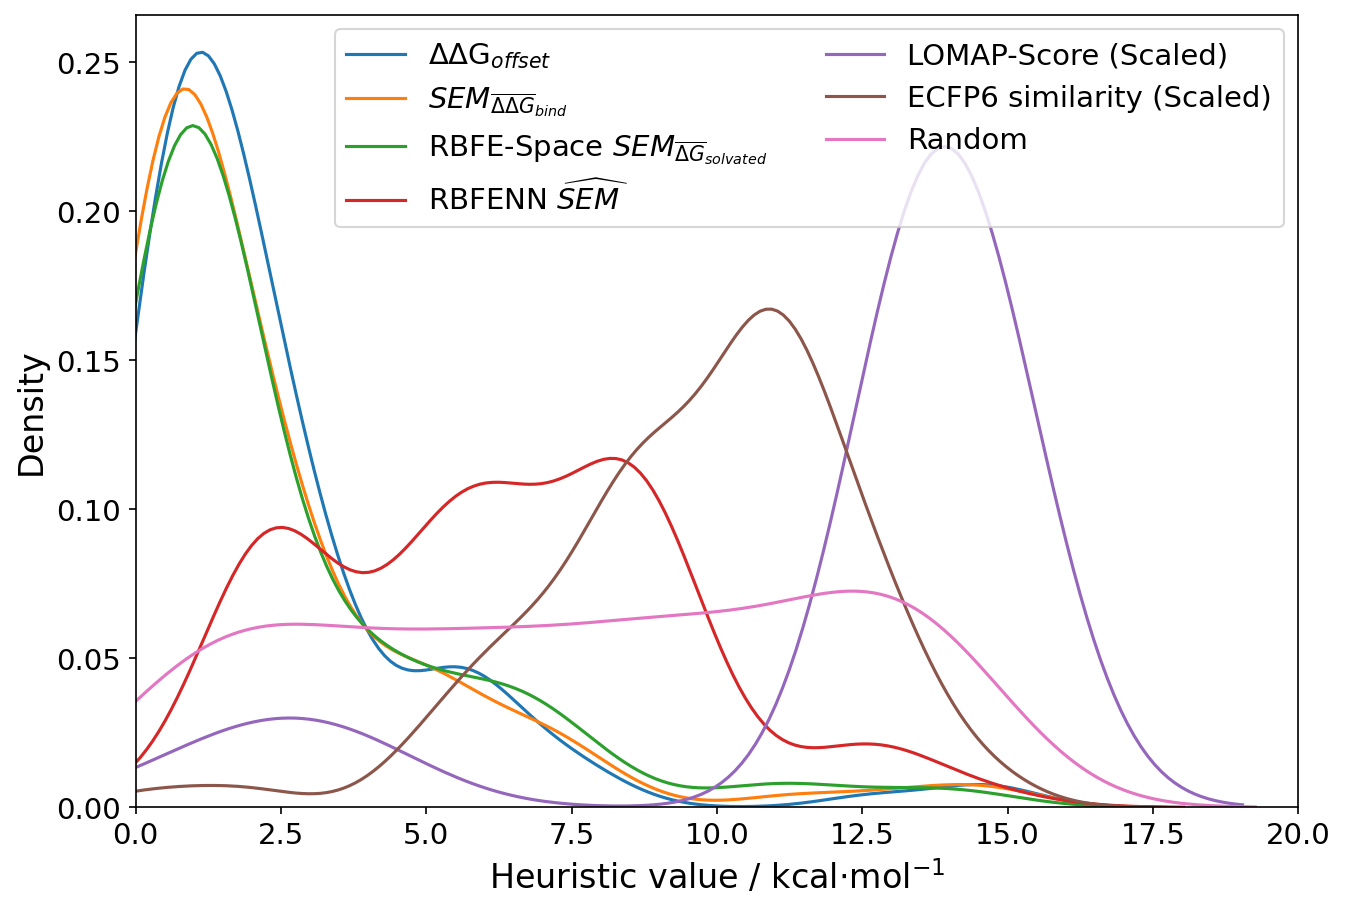

In [37]:
f, ax = plt.subplots(figsize=(10,7))


sns.kdeplot(ddg_offsets, label="$\Delta\Delta$G$_{offset}$", ax=ax)
sns.kdeplot(tyk2_sems_ddg_s, label="$SEM_{\overline{\Delta\Delta{G}}_{bind}}$", ax=ax)
sns.kdeplot(fepspace_sems_s, label="RBFE-Space $SEM_{\overline{\Delta{G}}_{solvated}}$", ax=ax)
sns.kdeplot(pred_sems_s, label="RBFENN $\widehat{SEM}$", ax=ax)
sns.kdeplot(lomap_scores_s, label="LOMAP-Score (Scaled)", ax=ax)
sns.kdeplot(ecfp6_s, label="ECFP6 similarity (Scaled)", ax=ax)
sns.kdeplot(random_vals, label="Random", ax=ax)


ax.set_xlabel("Heuristic value / kcal$\cdot$mol$^{-1}$")
ax.set_xlim(0, 20)

ax.legend(ncol=2)
plt.savefig("/home/jscheen/projects/FEPSPACE/figures/heuristic_densities.png", dpi=300)

plt.show()